When I saw the task for this challenge, I wondered how to solve it. At first, one thinks of supervised learning. However, in the context of the task one has the problem that the number of class assignments in a classification are predetermined. However, many matches will have only one POI and others will have many. Then it occurred to me that there is an algorithm of unsupervised learning that can solve exactly this problem:

## DBSCAN


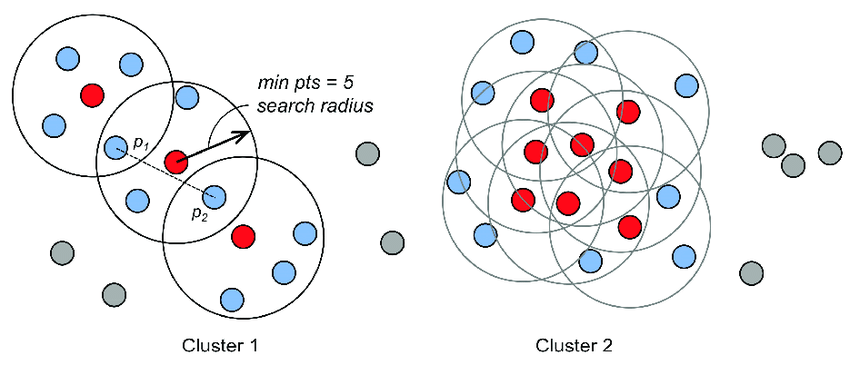

Here, a sphere is placed around each observation in n-dimensional space. As soon as the spheres of observations intersect, it is a cluster. The difficulty that arises here comes from the features. Longitude and latitude are very good, but the remaining features are categorical. So if you had a way to adjust the features so that they were cardinal, the method would probably work well. I have already tried dimension reductions to one-hot, which, as expected, did not work very well. 

Another difficulty arises from the size of the sphere. I have chosen it very small here.

What do you think? Post it in the comments.

In [ ]:
import cudf
from cuml import DBSCAN

In [ ]:
df = cudf.read_csv(
    "../input/foursquare-location-matching/test.csv",
    usecols=["id", "longitude", "latitude"]
)
df.head()

Normalization is not needed because longitude and latitude are scaled the same.

In [ ]:
dist=0.0001
matches = DBSCAN(eps=dist, min_samples=1, max_mbytes_per_batch=1024*7)
df["group"] = matches.fit_predict(df.drop(columns=["id"]))
df=df[["id", "group"]]

In [ ]:
unis = df.groupby(["group"]).unique()
unis.reset_index(inplace=True)

In [ ]:
sasu = cudf.read_csv("../input/foursquare-location-matching/sample_submission.csv")

In [ ]:
df = df.merge(
    right=unis,
    on="group",
    how="left"
).drop(columns=["group"]).rename(columns={"id_x": "id"})

del(unis)

In [ ]:
sasu = sasu.drop(columns=["matches"]).merge(
    right=df,
    on="id"
).rename(columns={"id_y": "matches"})

Ok, hier benutze ich doch nochmal Pandas

In [ ]:
import pandas as pd
sasu = sasu.to_pandas()
del cudf

sasu["matches"] = sasu.matches.map(lambda x: " ".join(x))

In [ ]:
sasu.to_csv("submission.csv", index=False)
sasu.head()